# Importação dos arquivos e das bibliotecas necessárias

---




##Importação de bibliotecas

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import metrics

# Configurações
%matplotlib inline
sns.set_theme(style="whitegrid")


## Importação de arquivos



In [ ]:
dataset = pd.read_csv(
    '/wage_train.csv',
                       index_col = 0, skipinitialspace = True)

dataset_test = pd.read_csv(
    '/wage_test.csv',
                       index_col = 0, skipinitialspace = True)


dataset.head()

# Estatísticas descritivas



Algumas categorias serão separadas em grupos para melhor visualização dos gráficos

In [18]:
dataset_graphs = dataset.copy()

# Separa as idades em grupos.
# Esses grupos serão usados apenas pros graficos
dataset_graphs["age"] = pd.cut(x=dataset['age'],
                        bins=[0,20,30,40,50,60,70,100],
                        labels=["0-20","21-30","31-40","41-50",
                                "51-60","61-70","71+"])

dataset_graphs["hours_per_week"] = pd.cut(x=dataset['hours_per_week'],
                        bins=[0,10,20,30,40,50,60,100],
                        labels=["0-10","11-20","21-30","31-40",
                                "41-50","51-60","61+"])

## Age

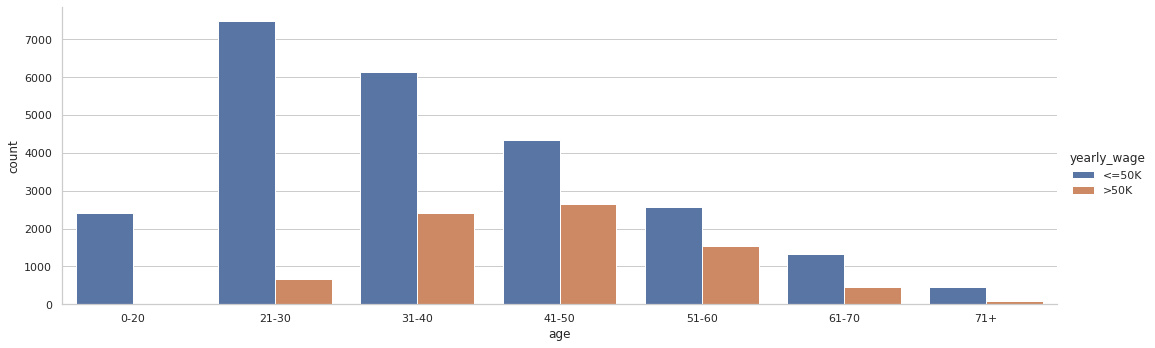

In [19]:
sns.catplot(x="age", hue="yearly_wage", 
            data=dataset_graphs, kind='count', aspect=3)

A grande maioria dos dados está entre os 21 e 40 anos. Além disso, até os 60 anos, quanto mais velho maior a proporção de pessoas com renda maior que 50 mil por ano. A partir dos 61 a proporção começa a cair, o motivo pode ser a aposentadoria, geração de pessoas com oportunidades diferentes, entre outros...

## Workclass

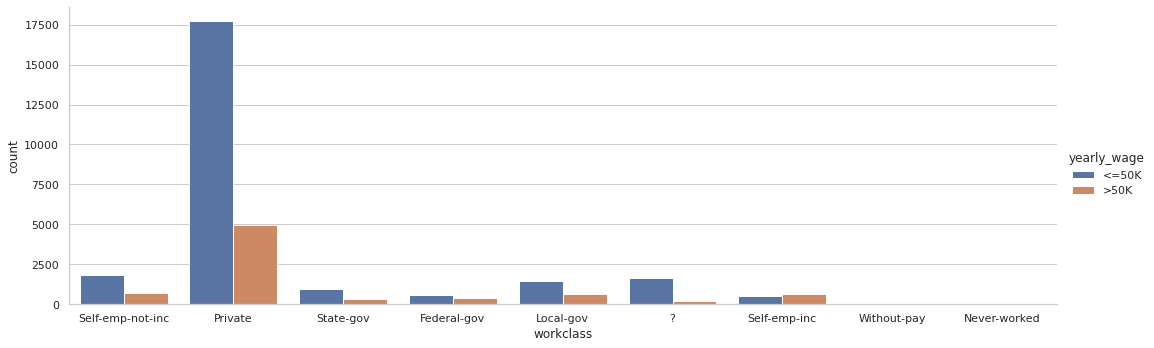

In [20]:
sns.catplot(x="workclass", hue="yearly_wage", 
            data=dataset_graphs, kind='count', aspect=3)

Como visto no gráfico, a chance de ter uma rendal anual acima de 50 mil é maior para federal-gov e para self-emp-inc. Dentre as três categorias relacionadas ao governo, a federal é a que tem uma proporção mais alta. Para aqueles sem dado a porcentagem de '>50k' é muito menor que em todas as outras categorias.

## Education

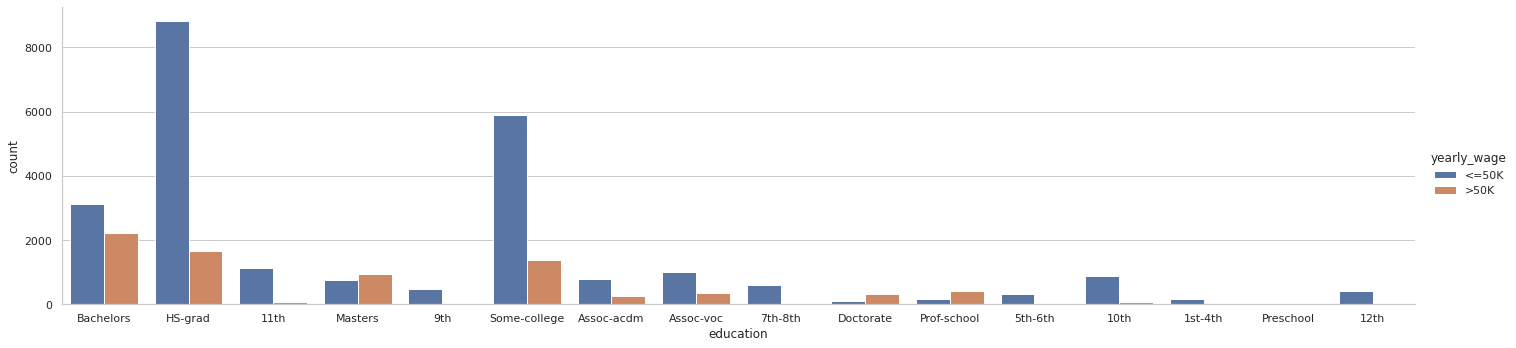

In [21]:
sns.catplot(x="education", hue="yearly_wage", 
            data=dataset_graphs, kind='count', aspect=4)

O gráfico nos mostra que quanto maior o grau de escolaridade, maior a chance de haver uma renda anual acima de 50 mil, como visto quando se compara graduação, mestrado e doutorado. O curioso é que prof-school apresenta uma proporção semelhante ao doutorado. Nas qualificações mais altas a renda cresce enquanto a quantidade de individuos diminui, como é esperado.

## Occupation

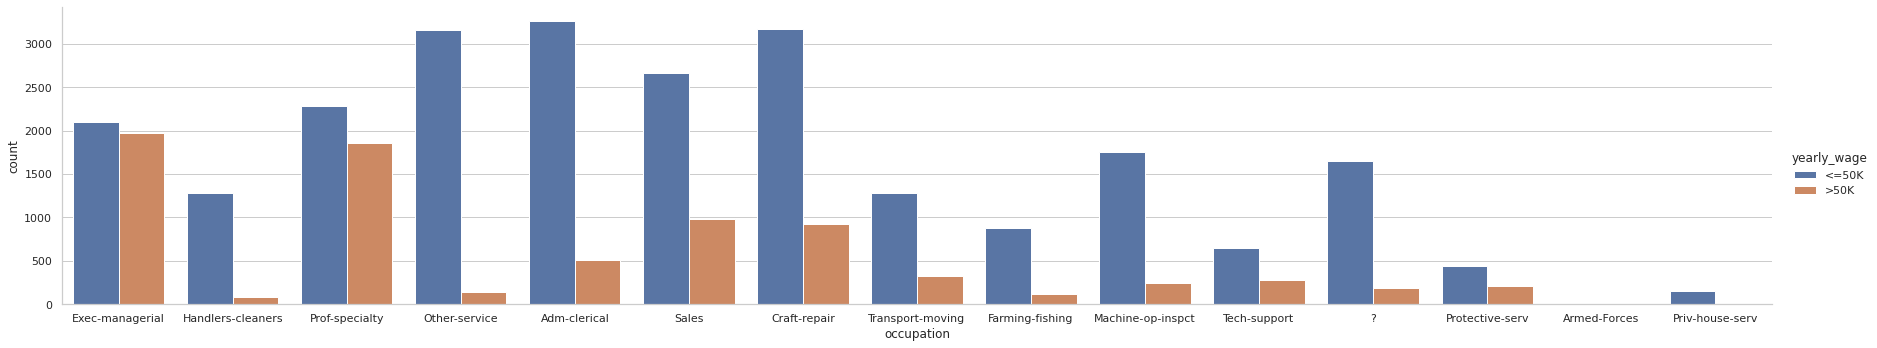

In [22]:
sns.catplot(x="occupation", hue="yearly_wage", 
            data=dataset_graphs, kind='count', aspect=5)

No gráfico de ocupações é possível ver que normalmente possuem relação direta com a renda anual, visto que cada as categorias possuem proporções distintas. A maioria das pessoas com renda acima de 50 mil por ano tem Exec-managerial ou Prof-specialty como ocupação. 

## Race

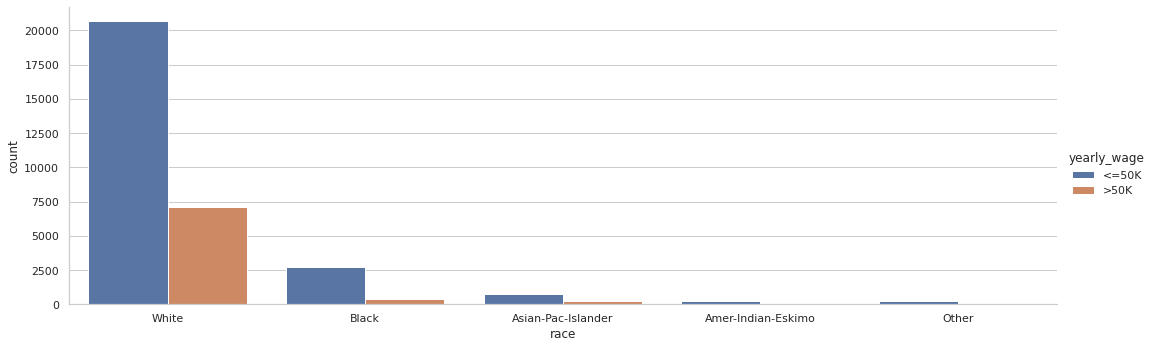

In [23]:
sns.catplot(x="race", hue="yearly_wage", 
            data=dataset_graphs, kind='count', aspect=3)

É possível notar no grafico que, proporcionalmente, a renda anual acima de 50 mil muda entre as etnia, sendo maior entre pessoas brancas. O dataset conta com uma discrepância muito grande na quantidade de dados de cada etnia, sendo aproxidamente 28 mil entradas da etnia branca e apenas 4 mil para a etnia com o segundo maior número.

## Sex

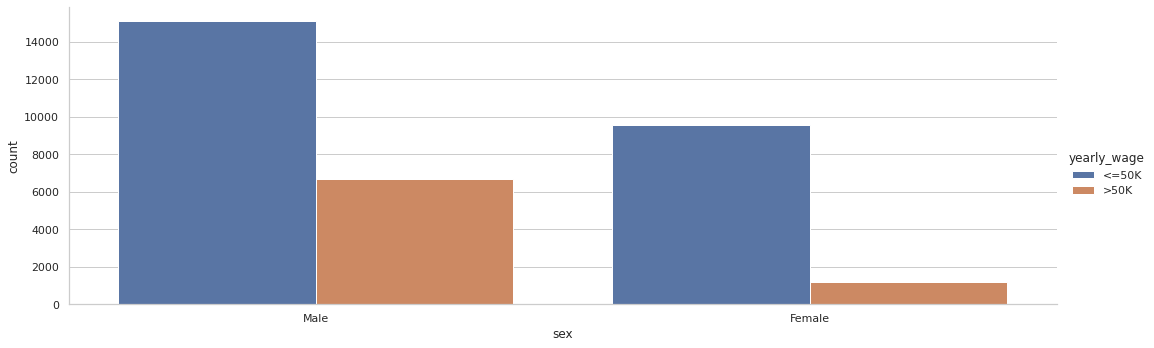

In [24]:
sns.catplot(x="sex", hue="yearly_wage", 
            data=dataset_graphs, kind='count', aspect=3)

Se pode notar que, percentualmente, há bem mais homens com renda acima de 50 mil do que mulheres o que torna um fator significativo para a nossa análise. 

## Hours per week

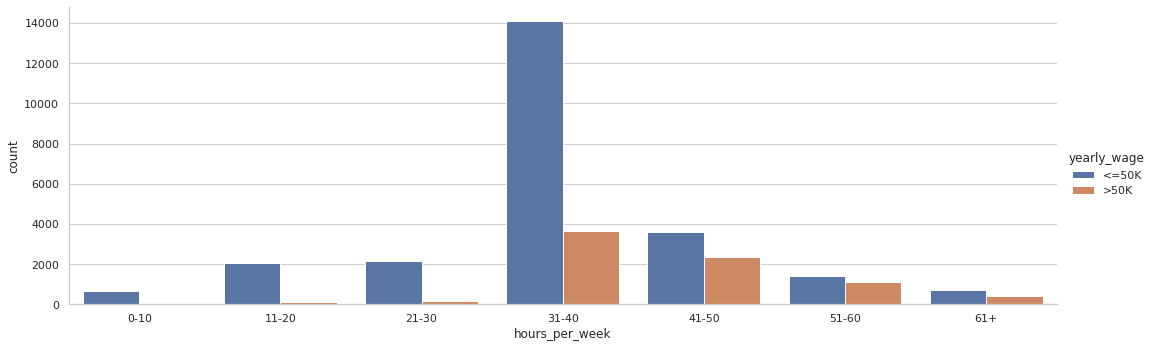

In [25]:
sns.catplot(x="hours_per_week", hue="yearly_wage", 
            data=dataset_graphs, kind='count', aspect=3)

Pelo gráfico é possível ver que a grande maioria das pessoas nesse dataset trabalham entre 31 e 40 hora por semana, que é o que se espera normalmente. Também é notável que a quantidade de pessoas que trabalha entre 41 e 60 horas é menor, porem a porcentagem dessas pessoas que ganham mais que 50 mil por ano é muito maior.

## Native country

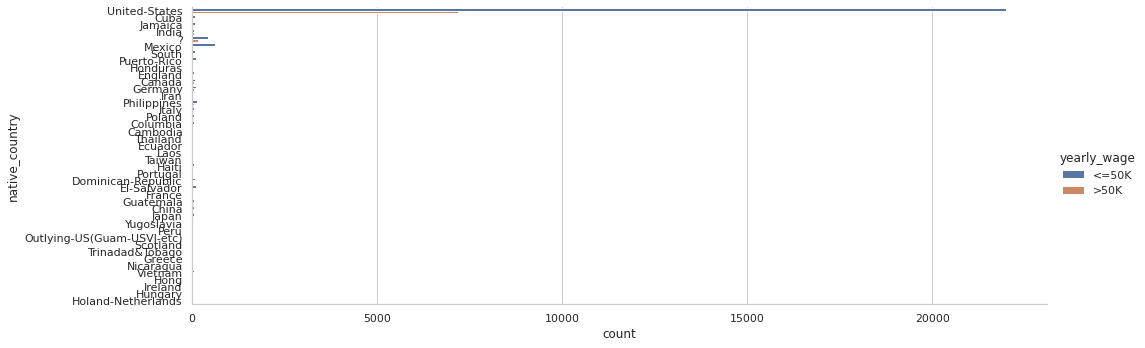

In [26]:
sns.catplot(y="native_country", hue="yearly_wage", 
            data=dataset_graphs, kind='count', aspect=3)

No dataset majoritariamente as pessoas são dos EUA sendo a quantidade de dados de outros países quase irrisória em comparação.

## Features a serem desconsideradas 

Devido a grande dispariedade de dados, optei por remover race e native_country. Além disso, as colunas education_num e education são redundantes, por isso mantive apenas education_num. Ademais, capital_gain e	capital_loss são majoritariamente valores zero, por isso também removi eles.
Por fim, julguei 'fnlwgt', 'marital_status' e 'relationship' como pouco relevantes para o salário anual, então também removi

In [27]:
dataset.drop('race', inplace=True, axis=1)
dataset.drop('native_country', inplace=True, axis=1)
dataset.drop('education', inplace=True, axis=1)
dataset.drop('capital_gain', inplace=True, axis=1)
dataset.drop('capital_loss', inplace=True, axis=1)
dataset.drop('fnlwgt', inplace=True, axis=1)
dataset.drop('relationship', inplace=True, axis=1)
dataset.drop('marital_status', inplace=True, axis=1)

dataset_test.drop('race', inplace=True, axis=1)
dataset_test.drop('native_country', inplace=True, axis=1)
dataset_test.drop('education', inplace=True, axis=1)
dataset_test.drop('capital_gain', inplace=True, axis=1)
dataset_test.drop('capital_loss', inplace=True, axis=1)
dataset_test.drop('fnlwgt', inplace=True, axis=1)
dataset_test.drop('relationship', inplace=True, axis=1)
dataset_test.drop('marital_status', inplace=True, axis=1)

dataset.head()

,age,workclass,education_num,occupation,sex,hours_per_week,yearly_wage
0,50,Self-emp-not-inc,13,Exec-managerial,Male,13,<=50K
1,38,Private,9,Handlers-cleaners,Male,40,<=50K
2,53,Private,7,Handlers-cleaners,Male,40,<=50K
3,28,Private,13,Prof-specialty,Female,40,<=50K
4,37,Private,14,Exec-managerial,Female,40,<=50K


# Pré-processamento de dados

---



## Checagem e troca dos valores faltando

In [28]:
for col in dataset.columns:
    dataset[col].replace('?', np.nan, inplace=True)
    #Para checar quantos valores faltam originalmente, comentar linha abaixo
    dataset[col].fillna(dataset[col].mode()[0], inplace=True)

for col in dataset_test.columns:
    dataset_test[col].replace('?', np.nan, inplace=True)
    #Para checar quantos valores faltam originalmente, comentar linha abaixo
    dataset_test[col].fillna(dataset_test[col].mode()[0], inplace=True)

dataset.isnull().sum() 

age               0
workclass         0
education_num     0
occupation        0
sex               0
hours_per_week    0
yearly_wage       0
dtype: int64

## Tratamendo das variáveis categóricas

### Codificação das variáveis em labels

In [29]:
labelencoder = LabelEncoder()
need_label = []
need_label_test = []
types = dataset.dtypes
types_test = dataset_test.dtypes
# Procura quais colunas possuem objects
for x in types:
  if x == 'object':
    need_label.append(True)
  else:
    need_label.append(False)

for x in types_test:
  if x == 'object':
    need_label_test.append(True)
  else:
    need_label_test.append(False)

columns_need_label = dataset.columns[need_label]
columns_need_label_test = dataset_test.columns[need_label_test]
# Lista para salvar as colunas que não vão precisar de encoder
columns_0_1 = []
columns_0_1_test = []
# Transforma as colunas de objetos em labels
for x in columns_need_label:
  dataset[x] = labelencoder.fit_transform(dataset[x])
  # Verifica o valor maximo da label de cada coluna
  max = dataset[x].max()
  # Se a label for igual a 1, existem apenas dois valores possíveis (0 e 1)
  # Portanto, não sera necessário usar o encoder nessas colunas
  if max == 1:
    columns_0_1.append(x)

for x in columns_need_label_test:
  dataset_test[x] = labelencoder.fit_transform(dataset_test[x])
  # Verifica o valor maximo da label de cada coluna
  max = dataset_test[x].max()
  # Se a label for igual a 1, existem apenas dois valores possíveis (0 e 1)
  # Portanto, não sera necessário usar o encoder nessas colunas
  if max == 1:
    columns_0_1_test.append(x)

dataset.head()

,age,workclass,education_num,occupation,sex,hours_per_week,yearly_wage
0,50,5,13,3,1,13,0
1,38,3,9,5,1,40,0
2,53,3,7,5,1,40,0
3,28,3,13,9,0,40,0
4,37,3,14,3,0,40,0


### Codificação das labels em valores

In [30]:
# A codificação escolhida é o OneHotEncoder,
# se cria uma nova coluna com valor 1 ou 0 para cada valor de label
# Evita que o valor seja considerado em labels não hierarquicas
encoder = OneHotEncoder(sparse=False)

# Removo as colunas que possuem máximo igual a 1 da lista
columns_need_encoder = columns_need_label.difference(columns_0_1)
columns_need_encoder_test = columns_need_label_test.difference(columns_0_1_test)
# Um novo dataset com apenas as colunas codificadas é criado
dataset_encoded = pd.DataFrame(
    encoder.fit_transform(dataset[columns_need_encoder]))
encoded_columns = encoder.get_feature_names_out()
dataset_encoded.columns = encoded_columns

dataset_encoded_test = pd.DataFrame(
    encoder.fit_transform(dataset_test[columns_need_encoder_test]))
encoded_columns_test = encoder.get_feature_names_out()
dataset_encoded_test.columns = encoded_columns_test

# Retiro as colunas originais que foram codificadas do dataset principal
dataset.drop(dataset[columns_need_encoder], axis=1, inplace=True)
dataset_test.drop(dataset_test[columns_need_encoder_test], axis=1, inplace=True)

# Concateno o dataset codificado com o principal
dataset = pd.concat([dataset, dataset_encoded], axis=1)
dataset_test = pd.concat([dataset_test, dataset_encoded_test], axis=1)

dataset_test.head()

,age,education_num,sex,hours_per_week,occupation_0,occupation_1,occupation_2,occupation_3,occupation_4,occupation_5,...,occupation_12,occupation_13,workclass_0,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7
0,38,9,1,50,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,28,12,1,40,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,44,10,1,40,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,18,10,0,30,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,34,6,1,30,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Normalização dos valores

In [31]:
# As colunas que não foram codificadas precisam ser normalizadas
columns_need_normalize = []
columns_need_normalize_test = []

for x in dataset.columns:
  if x in encoded_columns:
    columns_need_normalize.append(False)
  else:
    columns_need_normalize.append(True)

for x in dataset_test.columns:
  if x in encoded_columns_test:
    columns_need_normalize_test.append(False)
  else:
    columns_need_normalize_test.append(True)

columns_need_normalize = dataset.columns[columns_need_normalize]
dataset[columns_need_normalize] = MinMaxScaler().fit_transform(
    dataset[columns_need_normalize])

columns_need_normalize_test = dataset_test.columns[columns_need_normalize_test]
dataset_test[columns_need_normalize_test] = MinMaxScaler().fit_transform(
    dataset_test[columns_need_normalize_test])


dataset_test.head(10)

,age,education_num,sex,hours_per_week,occupation_0,occupation_1,occupation_2,occupation_3,occupation_4,occupation_5,...,occupation_12,occupation_13,workclass_0,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7
0,0.287671,0.533333,1.0,0.500000,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.150685,0.733333,1.0,0.397959,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.369863,0.600000,1.0,0.397959,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.013699,0.600000,0.0,0.295918,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.232877,0.333333,1.0,0.295918,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.164384,0.533333,1.0,0.397959,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,0.630137,0.933333,1.0,0.316327,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,0.095890,0.600000,0.0,0.397959,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,0.520548,0.200000,1.0,0.091837,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,0.657534,0.533333,1.0,0.397959,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Treinamento dos dados

## Análise do problema

Estamos lidando com um problema de classificação, queremos dividir as entradas em dois grupos, '<=50k' e '>50k'. Para esse problema, utilizei Label Encoder para transformar grupos em números, alem disso, utilizei one hot encoder para separar os grupos em que o valor da label não é relevante. Para o metodo escolhi o random forest pois ele é mais preciso que a decision tree para problemas de classificação e reduz o over-fitting, os pontos negativos é que ele é mais lento e bem mais complexo. O one hot encoder não é tão bom pra modelos de arvores, porém como há poucas colunas extras mantive ele.

In [32]:
dataset.head()

,age,education_num,sex,hours_per_week,yearly_wage,occupation_0,occupation_1,occupation_2,occupation_3,occupation_4,...,occupation_12,occupation_13,workclass_0,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7
0,0.452055,0.800000,1.0,0.122449,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.287671,0.533333,1.0,0.397959,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.493151,0.400000,1.0,0.397959,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.150685,0.800000,0.0,0.397959,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.273973,0.866667,0.0,0.397959,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [33]:
first_column = dataset.pop('yearly_wage')
dataset.insert(0, 'yearly_wage', first_column)

#Testar as metricas
training_set, test_set = train_test_split(dataset,
                                          test_size = 0.2, random_state = 1)


X_train = training_set.iloc[:,1:27].values
Y_train = training_set.iloc[:,0].values
X_test = test_set.iloc[:,1:27].values
Y_test = test_set.iloc[:,0].values

classifier = RandomForestClassifier(n_estimators=200, oob_score=False)
classifier.fit(X_train,Y_train)
Y_pred = classifier.predict(X_test)


print(metrics.classification_report(Y_test, Y_pred))
print(metrics.confusion_matrix(Y_test, Y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87      4990
         1.0       0.58      0.48      0.52      1522

    accuracy                           0.80      6512
   macro avg       0.71      0.69      0.70      6512
weighted avg       0.79      0.80      0.79      6512

[[4462  528]
 [ 796  726]]


Para as métricas, escolhi a matriz de confusão para poder ter uma melhor visualização do problema e quais previsões foram corretas. E o f1-score para ver as porcentagens e ter uma visão melhor

# Aplicação dos testes

In [36]:
X_train = dataset.iloc[:,1:27].values
Y_train = dataset.iloc[:,0].values

classifier.fit(X_train,Y_train)
prediction = classifier.predict(dataset_test)
    
results = pd.DataFrame(prediction, columns = ['predictedValues'])
results.to_csv('predicted.csv')

/home/kettl/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
